###  1. 데이터 훈련 / 테스트 세트로 나누기

#### 1.1 데이터 불러오기  
① &nbsp; '케글'에서 당뇨병 데이터셋을 다운  

② &nbsp; 다운 받은 데이터셋.csv 파일을 깃허브에 업로드  

③ &nbsp; 판다스를 이용하여 RAW URL에서 데이터셋을 vs code로 불러옴  

④ &nbsp; 데이터가 잘 들어왔는지 `.head()`와 `.shape` 을 통해 확인

In [27]:
import pandas as pd

raw_url = 'https://raw.githubusercontent.com/fnzm159-oss/ai-study_miniproject_data/refs/heads/main/diabetes.csv'

df = pd.read_csv(raw_url)

print(df.head())
print()
print(df.shape)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

(768, 9)


#### 1.2 결측값 처리  
① &nbsp; **'Pregnancies'**, **'DiabetesPedigreeFunction'**, **'Outcome'** 을 제외한 다른 항목에서 0값이 나오는 것은 결측값으로 간주  

② &nbsp; 결측값의 처리는 **KNN Imputer 클래스**를 사용  
&nbsp; &nbsp; &nbsp; : 데이터 패턴을 반영하여 단순한 중앙값 보다 현실적인 값으로 채워 모델 성능 향상의 경우가 많아 이 방법을 채택

In [28]:
# 0값이 있을 경우 제거할 항목
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Age']

# KNNImputer 클래스를 사용하여 결측값 대치
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df[zero_cols] = imputer.fit_transform(df[zero_cols])

#### 1.3 데이터 훈련 / 테스트 세트 분류 
① &nbsp; 회의를 통해 'Insulin' 데이터는 제하기로 결정 (가정에서도 확인 가능한 수치를 통해서도 당뇨병을 예측할 수 있는 프로그램을 목표)  
② &nbsp; `'train_test_split()'`을 이용  
③ &nbsp;`'stratify'` 을 통해 훈련 세트와 테스트 세트가 원본 데이터와 동일한 클래스 분포를 가지도록 이용

In [29]:
# 'Insulin'열을 제외
# 'Outcome'열은 타깃으로 사용할거라 제외
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

# 제거 됐는지 확인
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,33.6,0.627,50.0
1,1,85.0,66.0,29.0,26.6,0.351,31.0
2,8,183.0,64.0,0.0,23.3,0.672,32.0
3,1,89.0,66.0,23.0,28.1,0.167,21.0
4,0,137.0,40.0,35.0,43.1,2.288,33.0


In [30]:
# 타깃으로 'Outcome'을 이용
y = df['Outcome']

In [31]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(X, y, stratify = y, random_state = 42)

###  2. 데이터 전처리

* StandardScaler 클래스를 사용해 훈련 세트와 테스트 세트를 표준화 전처리를 함
* 훈련 세트의 통계 값으로 테스트 세트를 변환해야 함

In [32]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

###  3. k-NN과 로지스틱 회귀 모델의 비교

#### 3.1 k-NN의 확률 예측

In [33]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors = 3)
kn.fit(train_scaled, train_target)
print(kn.score(train_scaled, train_target))
print(kn.score(test_input, test_target))

0.8697916666666666
0.3489583333333333


/home/oracle/miniconda3/envs/ai-study/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [34]:
import numpy as np
proba = kn.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=4))

[[0.6667 0.3333]
 [0.6667 0.3333]
 [1.     0.    ]
 [0.6667 0.3333]
 [0.     1.    ]]


#### 3.2 로지스틱 회귀

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

/home/oracle/miniconda3/envs/ai-study/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [36]:
print(lr.predict(X[:20]))

[1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0]


In [37]:
print(lr.predict_proba(X[:20]))

[[0.31863267 0.68136733]
 [0.9540453  0.0459547 ]
 [0.22868265 0.77131735]
 [0.95515771 0.04484229]
 [0.11383203 0.88616797]
 [0.85179865 0.14820135]
 [0.93020304 0.06979696]
 [0.35393604 0.64606396]
 [0.21878228 0.78121772]
 [0.96313272 0.03686728]
 [0.77481615 0.22518385]
 [0.1117697  0.8882303 ]
 [0.23731098 0.76268902]
 [0.20763811 0.79236189]
 [0.36196869 0.63803131]
 [0.60027099 0.39972901]
 [0.60938421 0.39061579]
 [0.79924974 0.20075026]
 [0.64467779 0.35532221]
 [0.76825117 0.23174883]]


다중분류

In [38]:
lr = LogisticRegression(C=0.3, max_iter=1000)
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7899305555555556
0.7239583333333334


[ knn과 로지스틱을 비교했을 훈련세트는 줄어 들었지만 테스트에서 매우 늘어남 ]  

knn  
0.8697916666666666  
0.3489583333333333

로지스틱  
0.7899305555555556  
0.7239583333333334  

==> 로지스틱 과소적합의 경향이 보임

In [39]:
print(lr.coef_, lr.intercept_)

[[ 0.41027964  1.04289619 -0.18891788 -0.03742545  0.69802214  0.22385831
   0.16651815]] [-0.85854454]


두 번째 특성인 'Glucose' 가 값에 예측에 가장 큰 영향을 준다는 것을 확인

###  4. 결정 트리

In [40]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

1.0
0.7239583333333334


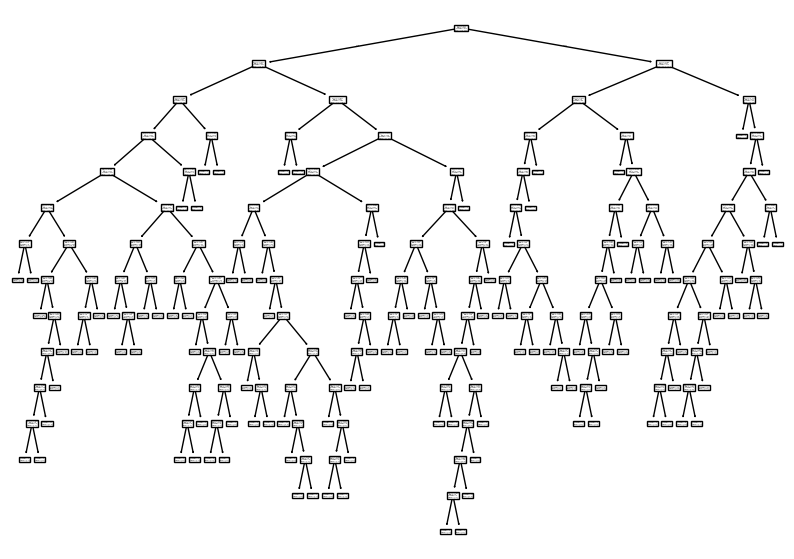

In [41]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

In [42]:
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8628472222222222
0.7708333333333334


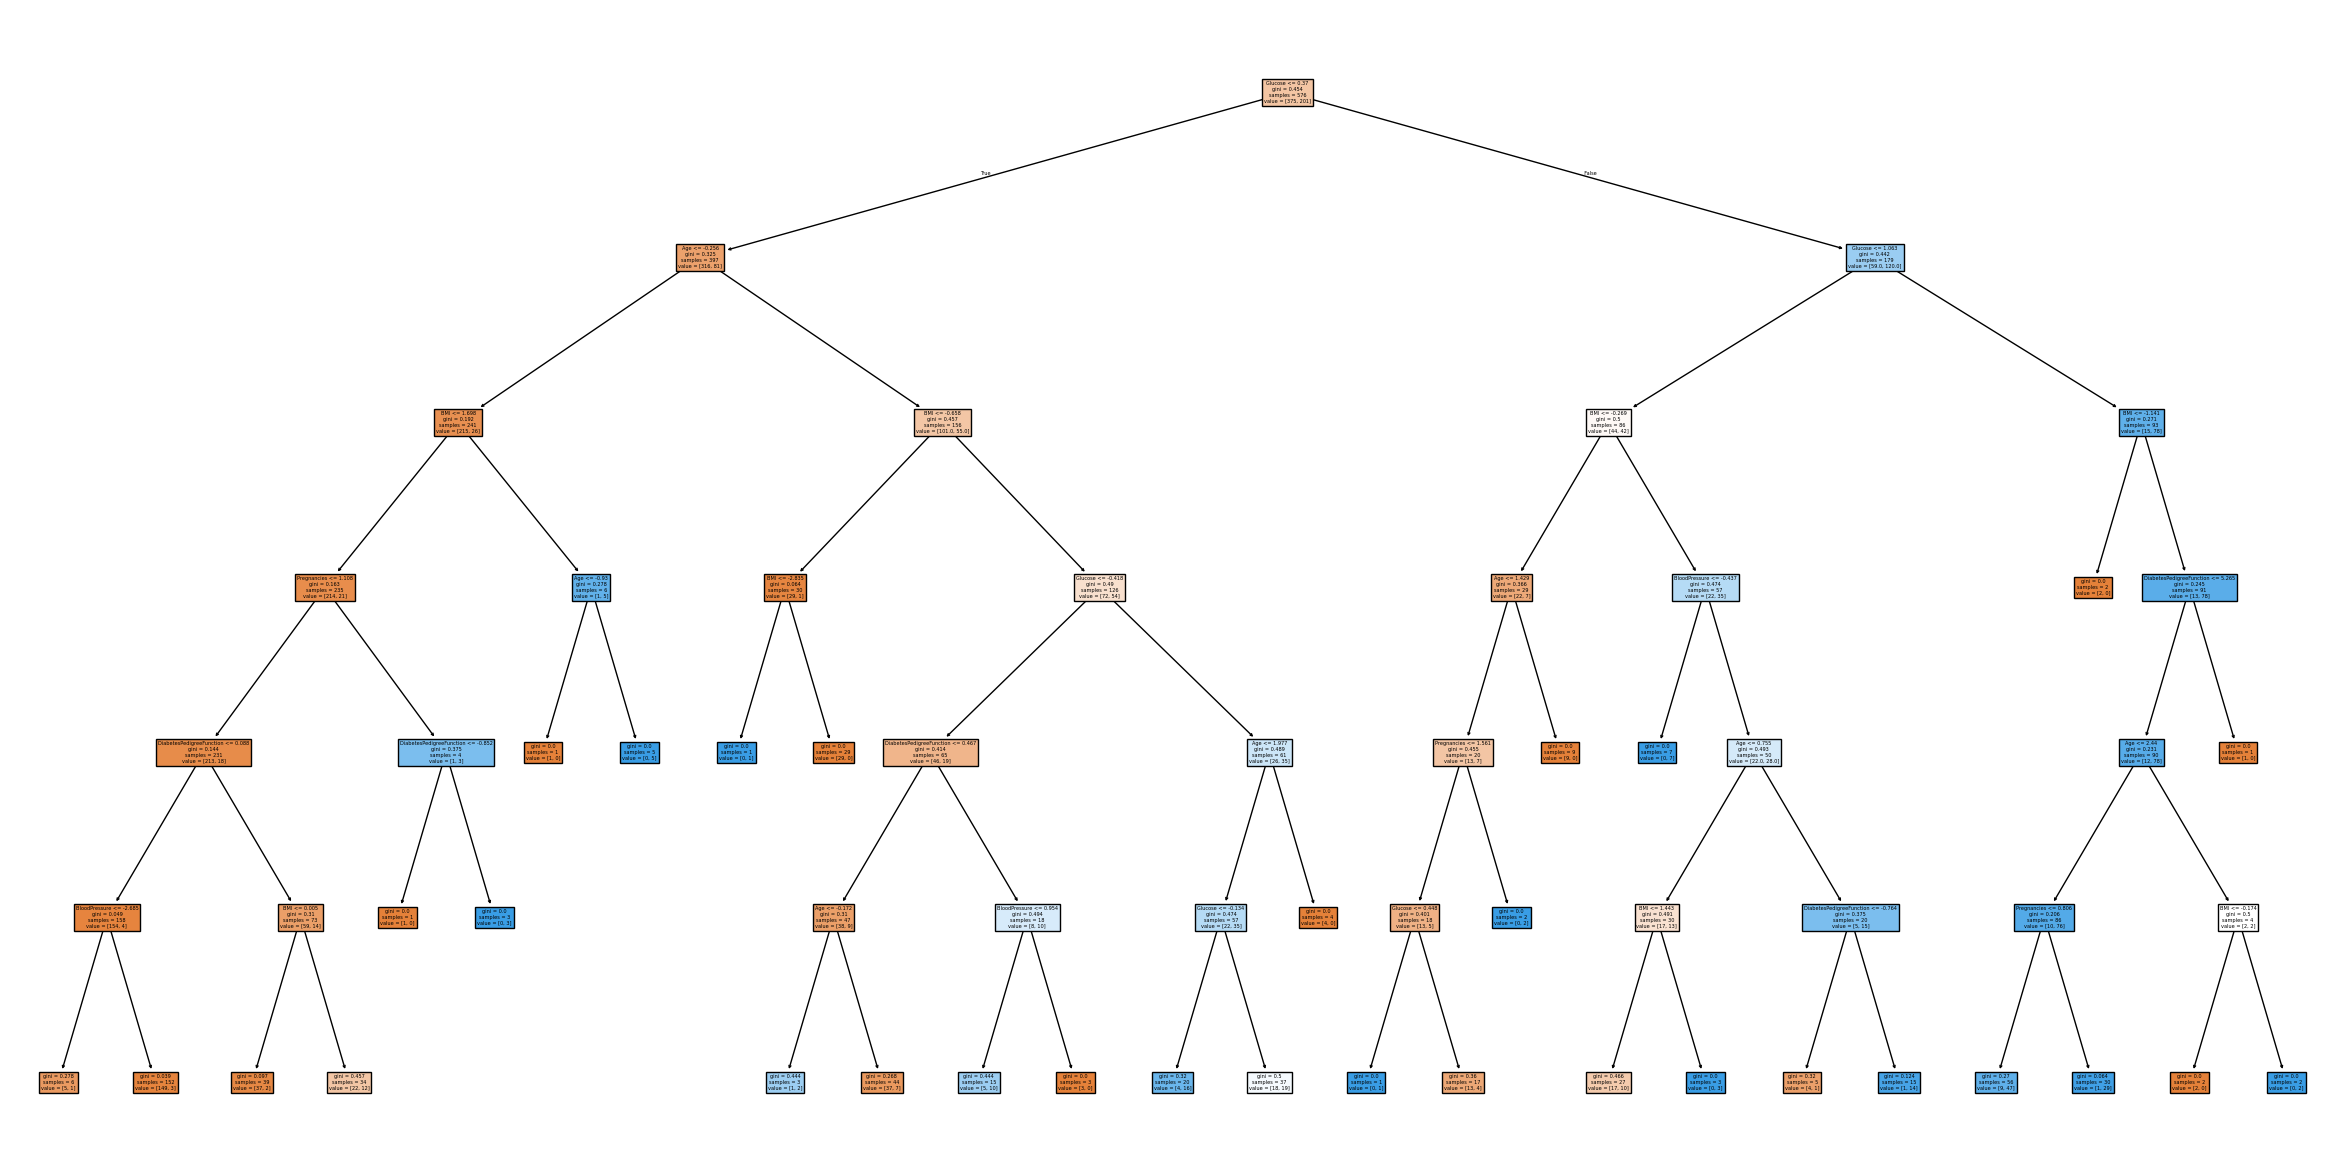

In [43]:
plt.figure(figsize = (30,15))
plot_tree(dt, filled=True, feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
plt.show()

In [44]:
dt = DecisionTreeClassifier(max_depth=9, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.9479166666666666
0.7239583333333334


In [45]:
print(dt.feature_importances_)

[0.04793048 0.39371079 0.09900714 0.01455284 0.20147018 0.10540021
 0.13792834]


In [46]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [48]:
print(sub_input.shape, val_input.shape)

(491, 7) (123, 7)


In [49]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

1.0
0.6422764227642277


[ 결정트리 depth = 1 ]  
0.7345276872964169  
0.7402597402597403  

[ 결정트리 depth = 2 ]  
0.7719869706840391  
0.7727272727272727  


[ 결정트리 depth = 3 ]  
0.7768729641693811  
0.7597402597402597


[ 결정트리 depth = 4 ]  
0.7980456026058632  
0.6948051948051948


[ 결정트리 depth = 5 ]  
0.8420195439739414  
0.7987012987012987


[ 결정트리 depth = 6 ]  
0.8648208469055375  
0.7467532467532467


[ 결정트리 depth = 7 ]  
0.9136807817589576  
0.7467532467532467


[ 결정트리 depth = 8 ]  
0.9527687296416938  
0.7402597402597403

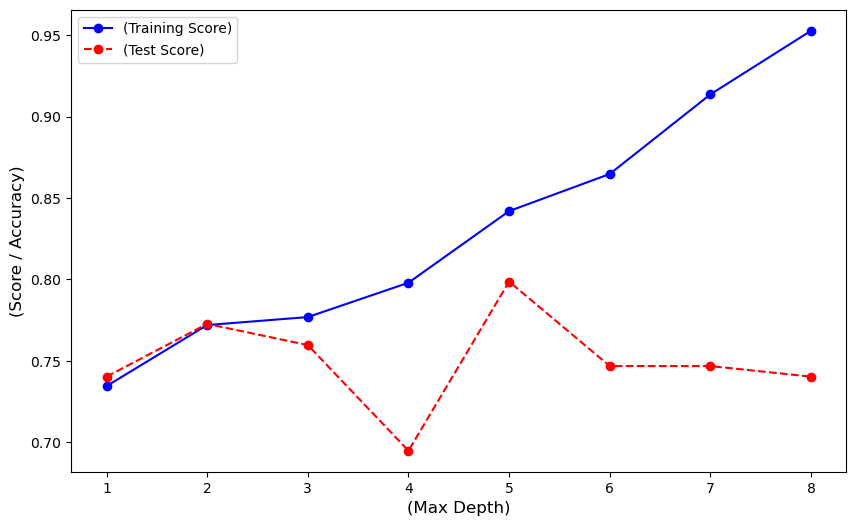

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 정의 (이전 실행에서 사용된 값)
depths = np.array([1, 2, 3, 4, 5, 6, 7, 8])
train_scores = np.array([0.7345, 0.7720, 0.7769, 0.7980, 0.8420, 0.8648, 0.9137, 0.9528])
test_scores = np.array([0.7403, 0.7727, 0.7597, 0.6948, 0.7987, 0.7468, 0.7468, 0.7403])

# 3. 그래프 설정 및 플롯
plt.figure(figsize=(10, 6))


plt.plot(depths, train_scores, label='(Training Score)', marker='o', linestyle='-', color='blue')
plt.plot(depths, test_scores, label='(Test Score)', marker='o', linestyle='--', color='red')
plt.xlabel('(Max Depth)', fontsize=12)
plt.ylabel('(Score / Accuracy)', fontsize=12)
plt.legend(fontsize=10)


### Depth = 5에서 테스트 점수가 가장 높은 것을 확인 가능